# Logistic Regression Modeling

Our first attempt at modeling will involve logistic regression.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, roc_curve, auc, confusion_matrix, recall_score,
    precision_score, recall_score, f1_score, accuracy_score, plot_roc_curve
)

from src.seed import SEED
from src.helper import confmat, praf1

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# import our data
train = pd.read_csv("../data/processed/train.csv")

In [3]:
# split data up
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

In [4]:
# identify class imbalance
y_train.value_counts()

False    1603
True      271
Name: churn, dtype: int64

Our data is severely imbalance to account for this we'll use synthetic over sampling on our minority class.

In [5]:
# account for class imbalance
sm = SMOTENC(categorical_features=np.arange(19, 69), random_state=SEED, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Baseline Model

First we'll create a vanilla model using all features and no hyper parameter tuning. Just a plain old model, and see how it does on our training and testing data.

In [6]:
# create vanilla model
logreg = LogisticRegressionCV(solver="liblinear", random_state=SEED)

logreg.fit(X_train, y_train)

train_pred = logreg.predict(X_train)
test_pred = logreg.predict(X_test)

In [7]:
# output precision, recall, accuracy, f1_score for training
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.963398,0.870243,0.91859,0.914454
Testing,0.600000,0.230769,0.86560,0.333333


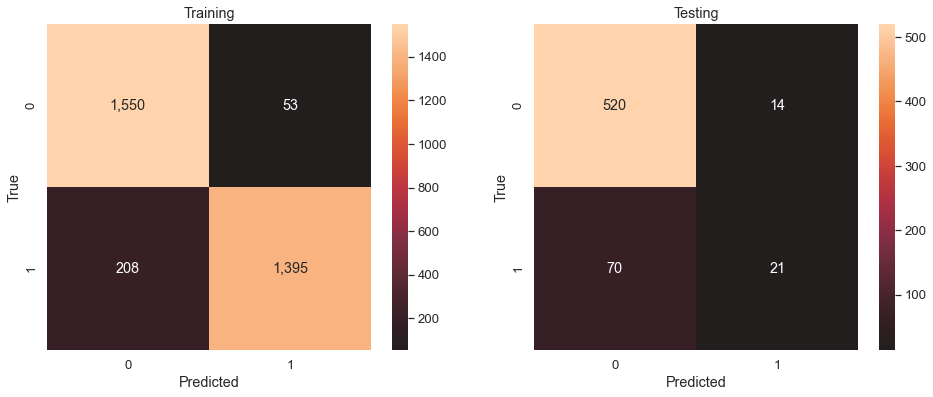

In [8]:
# output confusion matrix of training and test results
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])
plt.show()

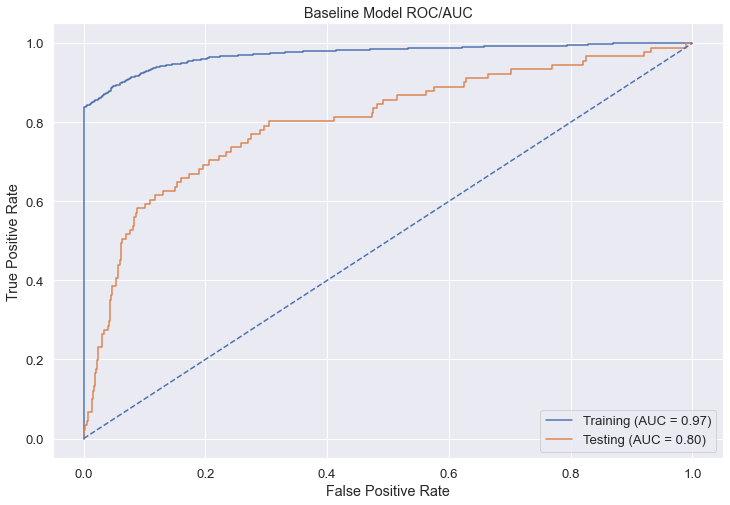

In [9]:
# Output ROC and AUC for our training and testing
fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(logreg, X_train, y_train, ax=ax, name="Training")
plot_roc_curve(logreg, X_test, y_test, ax=ax, name="Testing")

line = np.linspace(0, 1)
plt.plot(line, line, "b--")

plt.title("Baseline Model ROC/AUC")
plt.show()

Analysis: Our baseline vanilla model performs poorly during tests. Although our accuracy is about 86%, we have a recall score of 23%. Meaning that we are misclassifying about 77% of customers who will soon leave.

We'll have to adjust our hyper parameters as our model is over fitting to our training data, as we can see by the large difference in our F1 scores.

## Hyper Parameter Tuning - Recall

Since our baseline model was over fitting our data and had poor recall, we'll try to optimize our next model for recall.

In [10]:
# create Parameter Grid to search through as well as a Grid Search
param_grid = {
    "C": np.linspace(0, 1, 100),
    "fit_intercept": [True, False]
}

grid_search = GridSearchCV(LogisticRegression(random_state=SEED), param_grid, scoring="recall", n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

train_pred = grid_search.predict(X_train)
test_pred = grid_search.predict(X_test)

In [11]:
# Output training and testing results and our best params
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.711051,0.979414,0.790705,0.823931
Testing,0.251678,0.824176,0.617600,0.385604


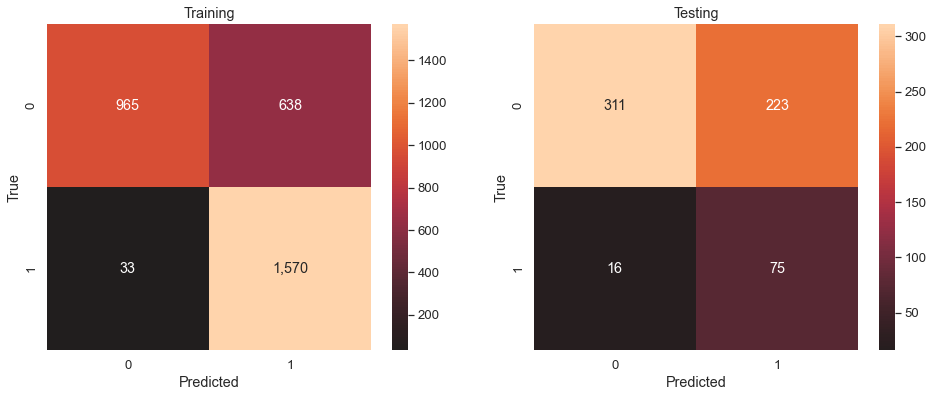

In [12]:
# output confusion matrix of training and test results
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])
plt.show()

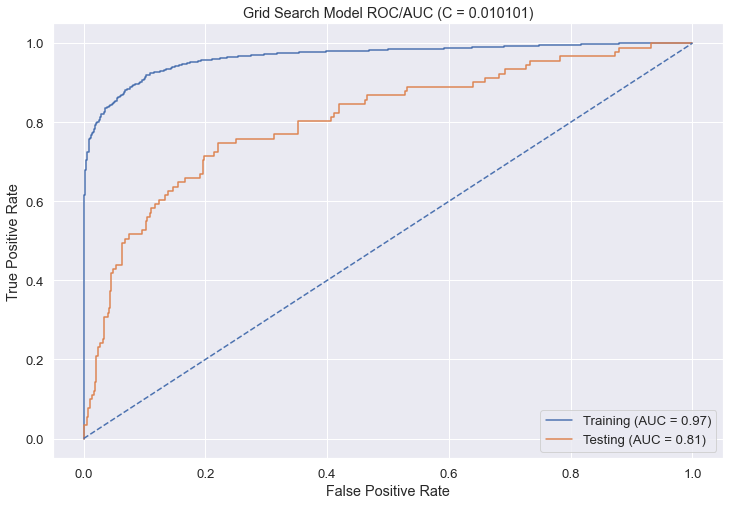

In [13]:
# output ROC curve and auc for our model
fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(grid_search, X_train, y_train, ax=ax, name="Training")
plot_roc_curve(grid_search, X_test, y_test, ax=ax, name="Testing")

line = np.linspace(0, 1)
plt.plot(line, line, "b--")

plt.title(f"Grid Search Model ROC/AUC (C = {grid_search.best_params_['C']:g})")
plt.show()

We can see that our new model has gone in the right direction and reduced over-fitting. Our training scores have dropped, but our testing scores specifically recall, have jumped significantly. We can attribute this to not fitting an intercept.

The confusion matrix for our new model shows visually our higher false positive rate, however in our scenario recall > precision.

We should still look to optimize our model more by looking to find a balance between our recall and precision, in such a case we'd optimize our f1 score.

## Hyper Parameter Tuning - F1 Score

Our previous model showed us that we should not fit the intercept on our model, and that we should continue to optimize, seeking to balance out our recall and precision.

In [14]:
# create Parameter Grid to search through as well as a Grid Search
param_grid = {
    "C": np.concatenate((np.linspace(0, 1, 100), np.linspace(1, 1e5, 100))),
    "fit_intercept": [True, False]
}

grid_search2 = GridSearchCV(LogisticRegression(random_state=SEED), param_grid, scoring="f1", n_jobs=-1)
grid_search2.fit(X_train, y_train)

train_pred = grid_search2.predict(X_train)
test_pred = grid_search2.predict(X_test)

In [15]:
# Output training and testing results and our best params
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.962095,0.870867,0.918278,0.914211
Testing,0.600000,0.230769,0.865600,0.333333


Optimizing for f1, shows that we actually perform worse on training data.

It appears our model has reached its plateau. We shall move on to other classification models and see if they fare better.

## Final Testing

Using our model optimized for recall we will see performance on a completely separate testing set.

In [16]:
# import data
test = pd.read_csv("../data/processed/test.csv")
X = test.iloc[:, :-1]
y = test.iloc[:, -1]

pred = grid_search.predict(X)

In [17]:
# output test results
praf1(y, pred, "Final Testing")

,precision,recall,accuracy,f1
Final Testing,0.273684,0.859504,0.648681,0.41517


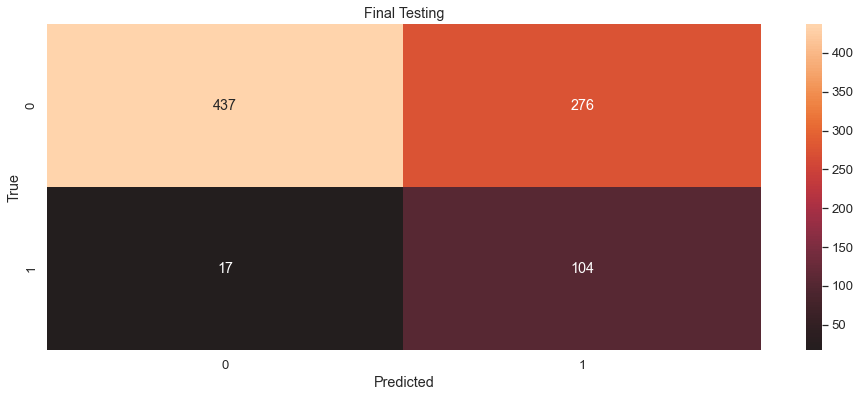

In [18]:
# output confusion matrix of results
confmat([y], [pred], ["Final Testing"])
plt.show()

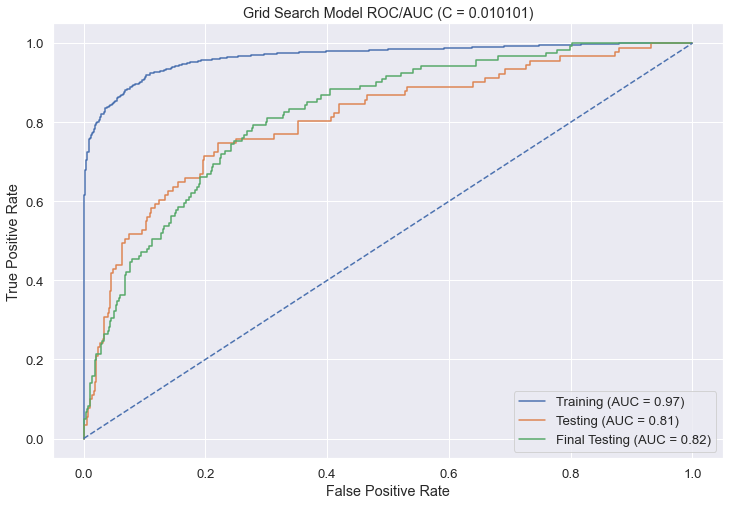

In [19]:
# output ROC curve and auc for our model
fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(grid_search, X_train, y_train, ax=ax, name="Training")
plot_roc_curve(grid_search, X_test, y_test, ax=ax, name="Testing")
plot_roc_curve(grid_search, X, y, ax=ax, name="Final Testing")

line = np.linspace(0, 1)
plt.plot(line, line, "b--")

plt.title(f"Grid Search Model ROC/AUC (C = {grid_search.best_params_['C']:g})")
plt.show()